# Motivating example: betting strategies in monte carlo games

In [1]:
%%file roll.py
"""
rolls a slightly biased (100-sided) die
"""

import random


def win(x):
    '''
    a simple win/loss: where win if (100 > x > 50)
    '''
    return int(bool(100 > x > 50))


def die():
    '''     
    a simple win/loss: where win if (100 > random(1,100) > 50)
    '''         
    return win(random.randint(1,100))


# EOF

Overwriting roll.py


In [2]:
%%file use_roll.py
"""
usage testing of roll
"""

import roll

def roll_dice(N):
    "roll a biased 100-sided die N times"
    rolls = []
    for i in range(N):
        rolls.append(roll.die())
    return rolls


if __name__ == '__main__':
    N = 25
    print(roll_dice(N))


# EOF

Overwriting use_roll.py


In [3]:
!python use_roll.py

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


In [4]:
%%file strategy.py
"""
betting strategies

forked from: http://pythonprogramming.net/dashboard/#tab_montecarloyo
"""

import roll


def simple(funds, initial_wager, wager_count, *args):
    '''
    Simple bettor, betting the same amount each time.
    '''
    value = funds
    wager = initial_wager
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    while currentWager <= wager_count:
        if roll.die():
            value += wager
            history[currentWager] = value
        else:
            value -= wager
            if value <= 0:
                break
            history[currentWager] = value
        currentWager += 1

    return history


def martingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    '''martingale bettor, "doubling-down" (actually, "*scaling-down")'''
    value = funds
    wager = initial_wager
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if roll.die():
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            if roll.die():
                wager = previousWagerAmount * wscale
                if (value - wager) < 0:
                    wager = value
                value += wager
                history[currentWager] = value
                wager = initial_wager
                previousWager = 'win'
            else:
                wager = previousWagerAmount * lscale
                if (value - wager) < 0:
                    wager = value
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history


def dAlembert(funds, initial_wager, wager_count, *args):
    '''d'Alembert bettor'''
    value = funds
    wager = initial_wager
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if wager == initial_wager:
                pass
            else:
                wager -= initial_wager
            if roll.die():
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            wager = previousWagerAmount + initial_wager
            if (value - wager) < 0:
                wager = value
            if roll.die():
                value += wager
                history[currentWager] = value
                previousWager = 'win'
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history


# EOF

Overwriting strategy.py


In [5]:
%%file use_strategy.py
"""
usage testing of strategy
"""

import numpy as np
import matplotlib.pylab as mpl
import strategy


def plot_trajectory(initial_funds, initial_bets, number_bets, *args, **kwds):
    "plot the rolls of a 100-sided die for all strategies"
    bettors = (strategy.simple, strategy.martingale, strategy.dAlembert)
    for bettor in bettors:
        mpl.plot(bettor(initial_funds, initial_bets, number_bets, *args, **kwds))
    # baseline
    mpl.plot(initial_funds * np.ones(number_bets+1), lw=2)
    return


if __name__ == '__main__':
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    W = L = 2

    plot_trajectory(initial_funds, initial_bet, number_bets, W, L)
    mpl.show()


# EOF

Overwriting use_strategy.py


In [6]:
!python2.7 use_strategy.py

In [7]:
%matplotlib inline

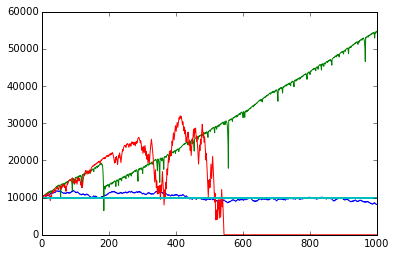

In [8]:
import matplotlib.pylab as mpl
import use_strategy as use
initial_funds = 10000
initial_bet = 100
number_bets = 1000
W = L = 2

use.plot_trajectory(initial_funds, initial_bet, number_bets, W, L)
mpl.show()

In [9]:
%%file trials.py
"""
monte carlo trials for betting strategies, and measures of success
"""

import numpy as np
from strategy import simple, martingale, dAlembert


def monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L):
    "monte carlo run for a betting strategy"
    history = []
    while len(history) < number_players:
        history.append(bettor(initial_funds, initial_bet, number_bets, W,L))
    return np.array(history)


def alive(history, number_players):
    "find the percentage of players that are not broke"
    return 100. * sum(np.asarray(history, bool).T[-1])/number_players


def gains(history, number_players, initial_funds):
    "find the percentage of players that have profited"
    return 100. * sum(history.T[-1] > initial_funds)/number_players


def profit(history, number_players, initial_funds):
    "find the total profit"
    return np.max(history.T[-1]) - initial_funds


def margin(history, number_players, initial_funds):
    "find the percentage the return on investment is over the initial funds"
    initial = number_players * initial_funds
    return 100.* (sum(history.T[-1]) - initial)/initial


# EOF

Overwriting trials.py


In [25]:
%%file use_trials.py
"""
usage testing of trials
"""

import numpy as np
import matplotlib.pylab as mpl
import trials


def plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L):
    "plot the Monte Carlo trajectories of a 100-sided die for the selected strategy"
    history = trials.monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
    mpl.plot(history.T)
    mpl.plot(initial_funds * np.ones(number_bets+1), lw=2)

    print "survived: {}%".format(trials.alive(history, number_players))
    print "profited: {}%".format(trials.gains(history, number_players, initial_funds))
    funds = trials.margin(history, number_players, initial_funds)
    funds = np.mean(funds)*initial_funds
    win = funds >= 0
    print "ave profit: {}${:.2f}".format('' if win else '-', funds if win else -funds)
    funds = trials.profit(history, number_players, initial_funds)
    win = funds >= 0
    print "max profit: {}${:.2f}".format('' if win else '-', funds if win else -funds)
    return 


if __name__ == '__main__':
    import strategy
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    number_players = 100
    bettor = strategy.martingale
    W = L = 2.0

    plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
    mpl.show()


# EOF

Overwriting use_trials.py


survived: 15.0%
profited: 15.0%
ave profit: -$221700.00
max profit: $53000.00


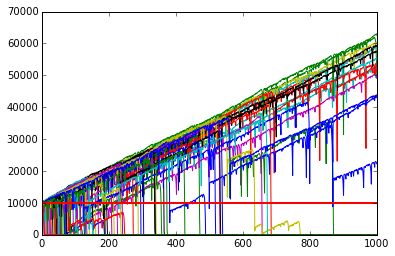

In [11]:
import matplotlib.pylab as mpl
import use_trials as use
import strategy
initial_funds = 10000
initial_bet = 100
number_bets = 1000
number_players = 100
bettor = strategy.martingale
W = L = 2.0

use.plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
mpl.show()

survived: 99.0%
profited: 27.0%
ave profit: -$179800.00
max profit: $5200.00


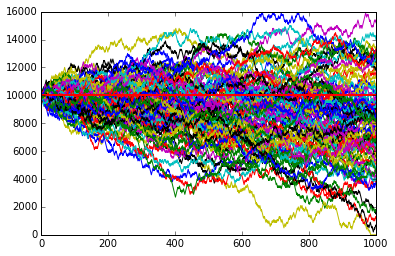

In [12]:
import matplotlib.pylab as mpl
import use_trials as use
import strategy
initial_funds = 10000
initial_bet = 100
number_bets = 1000
number_players = 100
bettor = strategy.simple
W = L = 2.0

use.plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
mpl.show()

In [41]:
%%file optimize.py
'''
monte carlo optimization of betting strategies for a given quantitative measure
'''

import numpy as np
from itertools import imap
import strategy
from trials import monte, alive, gains, profit, margin


def monte_stats(bettor, initial_funds, initial_bet, number_bets, number_players, W,L):
    "get the desired stats from a monte carlo run"
    settings = np.seterr(over='ignore', invalid='ignore')
    history = monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
    survived = alive(history, number_players)
    profited = gains(history, number_players, initial_funds)
    max_profit = profit(history, number_players, initial_funds)
    ave_profit = margin(history, number_players, initial_funds)
    np.seterr(**settings)
    return survived, profited, max_profit, ave_profit


def safety_metric(initial_funds, survived, profited, max_profit, ave_profit):
    "we define optimality with (4*profited + survived)/5"
    return (4*profited + survived)/5


def profit_metric(initial_funds, survived, profited, max_profit, ave_profit):
    "we define optimality with (max_profit - ave_profit)"
    return max_profit - (np.mean(ave_profit) * initial_funds)


def optimize_WL(metric, players=100, funds=None, bet=None, number_bets=None, symmetric=False):
    "soewhat hacky Monte Carlo optimization of betting parameters for martingale strategy"
    samples = int(np.random.uniform(100., 1000.)) if players is None else int(players)
    if funds is None: funds = np.random.uniform(1000. ,1000000.)
    if bet is None: bet = np.random.uniform(1. ,1000.)
    number_bets = int(np.random.uniform(10.,10000.)) if number_bets is None else int(number_bets)
    bettor = strategy.martingale
    
    W = np.random.uniform(0.1, 10., samples)
    L = W if symmetric else np.random.uniform(0.1, 10., samples)
    
    def measure(W,L):
        "let's hide this, because it's ugly (*groan*)" # good indicator a class should be built
        return metric(funds, *monte_stats(bettor, funds, bet, number_bets, samples, W,L))
    
    # use imap to run the monte carlo, because it's cool
    results = imap(measure, W,L)

    i = 0
    best_result = 0.0
    best_value = W[0],L[0]
    for result in results:
        if result > best_result:
            best_result = result
            best_value = W[i],L[i]
            print "best: %s @ %s" % (best_result, best_value)
        i += 1
        if not i%np.floor_divide(samples, 10):
            print "{:.2f}% done".format(100. * i / samples)

    return best_value


if __name__ == '__main__':
    initial_funds = 10000
    initial_bet = 100
    number_bets = 100
    number_players = 300    # XXX: THIS SHOULD BE MUCH LARGER
    metric = safety_metric
    symmetric = True

    print "optimizing W,L for symmetric=%s\n%s\n" % (symmetric, metric.__doc__)
    optimize_WL(metric, number_players, initial_funds, initial_bet, number_bets, symmetric)


# EOF

Overwriting optimize.py


In [42]:
!python2.7 optimize.py

optimizing W,L for symmetric=True
we define optimality with (4*profited + survived)/5

best: 2.33333333333 @ (8.5757103167409081, 8.5757103167409081)
best: 4.66666666667 @ (8.3045062569027834, 8.3045062569027834)
best: 51.4666666667 @ (0.30982064128937659, 0.30982064128937659)
best: 56.8 @ (0.30217794763987715, 0.30217794763987715)
best: 67.0666666667 @ (1.5010348603055301, 1.5010348603055301)
10.00% done
20.00% done
best: 73.7333333333 @ (1.6427232291502374, 1.6427232291502374)
30.00% done
40.00% done
50.00% done
60.00% done
best: 73.9333333333 @ (1.7790024945283196, 1.7790024945283196)
70.00% done
80.00% done
90.00% done
100.00% done


Now on to [the tutorial](efficient.ipynb)...